# Intro Task, Object Localization 

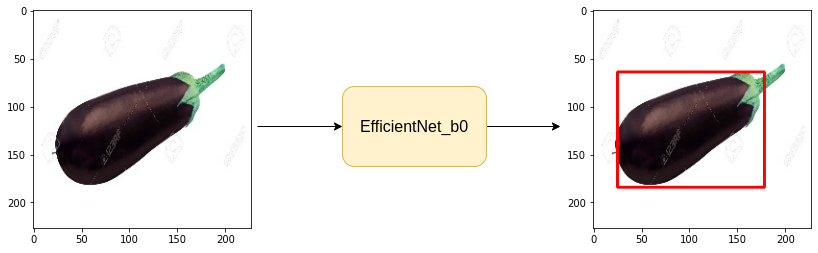

In [1]:
# install libraries/packages/modules 

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-80b98283
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-80b98283
  Resolved https://github.com/albumentations-team/albumentations to commit 30deec1ee4f3bf8e56c43baa894de970e609852b
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.0-py3-none-any.whl size=125696 sha256=42a9a33896e8435673cd7bf03ae7e36ab0bb4ffa1a5180222e6a422cd1a071b2
  Stored in directory: /tmp/pip-ephem-wheel-cache-as8mqbyj/wheels/51/4d/ab/5aafa8b980086fbc362946de7da4aa3df33aacb3da0da29b93
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1
L

In [2]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 22.77 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [5]:
CSV_FILE = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset/'

DEVICE = 'cuda'

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001
EPOCHS = 40
MODEL_NAME = 'efficientnet_b0'

NUM_COR = 4

In [6]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

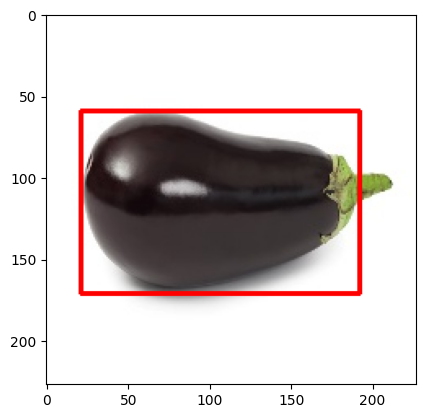

In [7]:
row = df.iloc[184]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)
bnd_box_img = cv2.rectangle(img, pt1, pt2, (255,0,0), 2) # image, starting point, ending point, bounding box color(red), thickness of box
plt.imshow(bnd_box_img)

In [8]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

# Augmentations

In [9]:
import albumentations as A

In [10]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
], bbox_params = A.BboxParams(format = 'pascal_voc', label_fields=['class_labels']))

valid_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
], bbox_params = A.BboxParams(format = 'pascal_voc', label_fields=['class_labels']))

# Create Custom Dataset

In [11]:
class ObjectLocalizationDataset(torch.utils.data.Dataset):
  def __init__(self, df, augmentations = None):
    self.df = df
    self.augmentations = augmentations
  
  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row = self.df.iloc[index]
    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax

    bbox = [[xmin, ymin, xmax, ymax]]

    img_path = DATA_DIR + row.img_path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentations: 
      data = self.augmentations(image = img, bboxes = bbox, class_labels = [None])
      img = data['image']
      bbox = data['bboxes'][0]
    img = torch.from_numpy(img).permute(2,0,1) / 255.0 #(h,w,c)->(c,h,w)
    bbox = torch.Tensor(bbox)
    return img, bbox

In [12]:
trainset = ObjectLocalizationDataset(train_df, train_augs)
validset = ObjectLocalizationDataset(valid_df, valid_augs)

In [13]:
print(f"Total examples in the trainset: {len(trainset)}")
print(f"Total examples in the validset: {len(validset)}")

Total examples in the trainset: 148
Total examples in the validset: 38


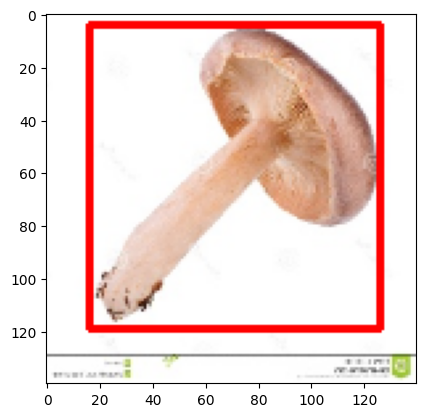

In [14]:
img, bbox = trainset[120]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [15]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
validloader = torch.utils.data.DataLoader(validset,batch_size=BATCH_SIZE,shuffle=False)

In [16]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [17]:
# loading one batch
for images, bboxes in trainloader:
  break

print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [18]:
from torch import nn 
import timm

In [19]:
class ObjectLocalModel(nn.Module):
  def __init__(self):
    super(ObjectLocalModel, self).__init__()
    
    self.backbone = timm.create_model(MODEL_NAME, pretrained=True,num_classes=4)

  def forward(self,images,gt_bboxes=None):
    bboxes = self.backbone(images)
    if gt_bboxes != None:
      loss = nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes,loss
    return bboxes

In [20]:
model = ObjectLocalModel()
model.to(DEVICE);

In [21]:
random_img = torch.rand(1,3,140,140).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [22]:
def train_fn(model,dataloader,optimizer):
  total_loss = 0.0
  model.train() # Dropout ON
  for data in tqdm(dataloader):
    images, gt_bboxes = data
    images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)
    bboxes,loss = model(images,gt_bboxes)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  return total_loss / len(dataloader)

In [23]:
def eval_fn(model,dataloader):
  total_loss = 0.0
  model.eval()
  with torch.no_grad():
    for data in tqdm(dataloader):
      images, gt_bboxes = data
      images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)
      bboxes, loss = model(images,gt_bboxes)
      total_loss += loss.item()
    return total_loss / len(dataloader)

#Training Loop

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [25]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('WEIGHTS ARE SAVED')
    best_valid_loss = valid_loss
  
  print(f'Epoch: {i+1} train loss: {train_loss} valid loss: {valid_loss}')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 1 train loss: 5176.602124023438 valid loss: 3832.761962890625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 2 train loss: 1839.8976440429688 valid loss: 1185.8819173177083


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 3 train loss: 1167.2810180664062 valid loss: 528.5388590494791


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 4 train loss: 774.9158203125 valid loss: 172.40503438313803


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 5 train loss: 542.6106506347656 valid loss: 248.68711853027344


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 6 train loss: 376.90565795898436 valid loss: 162.59048970540366


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 7 train loss: 284.47691955566404 valid loss: 204.69041951497397


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 8 train loss: 217.42662811279297 valid loss: 175.09835815429688


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 9 train loss: 157.64020690917968 valid loss: 153.14942932128906


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 10 train loss: 141.08430709838868 valid loss: 160.45110829671225


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 11 train loss: 141.19460678100586 valid loss: 181.9606170654297


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 12 train loss: 110.07569580078125 valid loss: 119.47203063964844


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 13 train loss: 95.16250381469726 valid loss: 99.17577870686848


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 14 train loss: 84.71137504577636 valid loss: 99.1019515991211


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 15 train loss: 78.91552963256837 valid loss: 96.08985392252605


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 16 train loss: 91.54652671813965 valid loss: 99.41027323404948


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 17 train loss: 76.06609878540038 valid loss: 83.38550313313802


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 18 train loss: 75.37938499450684 valid loss: 72.5319315592448


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 19 train loss: 59.669595336914064 valid loss: 94.51395161946614


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 20 train loss: 59.00811538696289 valid loss: 77.25752766927083


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 21 train loss: 78.78190307617187 valid loss: 69.62166595458984


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 22 train loss: 67.99486122131347 valid loss: 70.14362080891927


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 23 train loss: 55.965979766845706 valid loss: 67.20733388264973


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 24 train loss: 55.27179870605469 valid loss: 84.14197158813477


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 25 train loss: 46.918127822875974 valid loss: 64.72504425048828


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 26 train loss: 55.51002960205078 valid loss: 94.33146540323894


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 27 train loss: 62.76949119567871 valid loss: 103.20385233561198


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 28 train loss: 62.9505672454834 valid loss: 62.08328119913737


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 29 train loss: 63.06250495910645 valid loss: 87.49503580729167


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 30 train loss: 45.840884399414065 valid loss: 67.06203969319661


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 31 train loss: 38.848687744140626 valid loss: 65.73273468017578


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 32 train loss: 54.75234546661377 valid loss: 68.15595118204753


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 33 train loss: 51.58874282836914 valid loss: 57.50845209757487


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 34 train loss: 63.22438430786133 valid loss: 73.03396352132161


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 35 train loss: 50.759330940246585 valid loss: 58.07651138305664


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 36 train loss: 59.67692680358887 valid loss: 70.1250991821289


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 37 train loss: 37.81960678100586 valid loss: 58.37903594970703


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 38 train loss: 39.44385871887207 valid loss: 55.98580678304037


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 39 train loss: 46.257276916503905 valid loss: 75.41008631388347


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 40 train loss: 43.831657791137694 valid loss: 59.41997273763021


#Inference

In [26]:
import utils

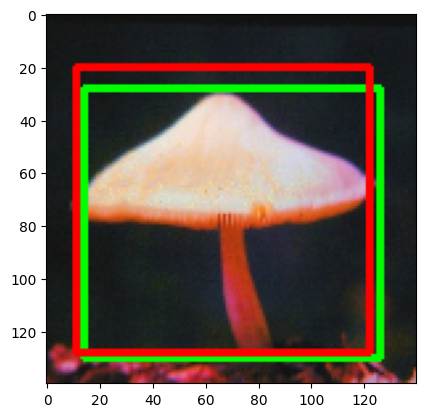

In [27]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():
  image, gt_bbox = validset[5] # (c,h,w)
  image = image.unsqueeze(0).to(DEVICE) # (batchsize, c, h, w)
  out_bbox = model(image) # getting the predicted bounding box
  utils.compare_plots(image, gt_bbox, out_bbox) # green is the ground truth bounding box, red is the predicted one